In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)
        
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # forward passing
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
earliest_stop = 5000
tolerance = 0.02

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
    data
).to(device)

# optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.01)
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=5e-4, lr=0.01)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > max(2 * early_stop_win_size, earliest_stop):
#         prev_start = epoch - 2 * early_stop_win_size
#         prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
#         val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
#         if val_acc_current < val_acc_previous - tolerance:
        if val_acc_current < np.max(val_acc) - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 validation acc = 0.058 , loss = 167.6129150390625
1000 training acc = 1.0 validation acc = 0.238 , loss = 0.002168478211387992
2000 training acc = 1.0 validation acc = 0.478 , loss = 0.0006425176397897303
3000 training acc = 1.0 validation acc = 0.504 , loss = 0.0005135911051183939
4000 training acc = 1.0 validation acc = 0.536 , loss = 0.00038924216642044485
5000 training acc = 1.0 validation acc = 0.59 , loss = 0.0002787215344142169
6000 training acc = 1.0 validation acc = 0.656 , loss = 0.0002021959808189422
7000 training acc = 1.0 validation acc = 0.7 , loss = 0.00014568056212738156
8000 training acc = 1.0 validation acc = 0.736 , loss = 0.00013355528062675148
9000 training acc = 1.0 validation acc = 0.762 , loss = 0.0001342909672530368


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.55788361e-04
  3.47637758e-03 4.63791564e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.51576309e-04 0.00000000e+00]
 [0.00000000e+00 9.39450343e-04 1.24587197e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 1.84259843e-05 ... 6.52520030e-05
  0.00000000e+00 0.00000000e+00]
 [1.69059698e-04 0.00000000e+00 1.89330836e-04 ... 1.03074135e-05
  1.31653417e-06 2.09690552e-04]
 [9.77544551e-05 0.00000000e+00 1.01752094e-05 ... 5.63848007e-05
  0.00000000e+00 0.00000000e+00]]

Sum final = 577



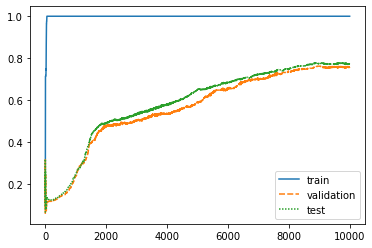

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/CiteSeer/SAGEConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.7580
Test Accuracy: 0.7740


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.8829


In [14]:
test_acc_all = [0.7730, 0.7660, 0.7850, 0.7740, 0.7610]
test_auc_all = [0.8842, 0.8813, 0.8911, 0.8829, 0.8743]

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.7718
0.88276
0.00813387976306511
0.005391697320881444
